In [3]:
import os
os.chdir('C:/Users/devg2/Desktop/10 - Capstone Project - Medical Imaging 2.0')

In [4]:
import cntk; print(cntk.__version__)

2.5.1


In [5]:
import os
from PIL import Image
import numpy as np
import itertools
import random
import time
import matplotlib.pyplot as plt

import cntk as C


def split_line(line):
    splits = line.strip().split(',')
    return (splits[0], int(splits[1]))

def load_labels_dict(labels_file):
    with open(labels_file) as f:
        return dict([split_line(line) for line in f.readlines()[1:]])

def load_data(data_dir, labels_dict):
    for f in os.listdir(data_dir):
        key = f[:-4]
        label = labels_dict[key]
        image = np.array(Image.open(os.path.join(data_dir, f)), dtype = np.int16).flatten()
        yield np.hstack([image, int(label)])
        
def write_to_ctf_file(generator, test_file_name, train_file_name, pct_train = 0.9, rng_seed = 0):
    random.seed(rng_seed)
    labels = [l for l in map(' '.join, np.eye(4, dtype = np.int16).astype(str))]
    with open(test_file_name, 'w') as testf:
        with open(train_file_name, 'w') as trainf:
            lines = 0
            for entry in generator:
                rand_num = random.random()
                formatted_line = '|labels {} |features {}\n'.format(labels[int(entry[-1])], ' '.join(entry[:-1].astype(str)))
                if rand_num <= pct_train:
                    trainf.write(formatted_line)
                else:
                    testf.write(formatted_line)

                lines += 1
                if lines % 1000 == 0:                    
                    print('Processed {} entries'.format(str(lines)))

In [6]:
train_data_dir = os.path.join('data', 'train')
labels_file = os.path.join('data', 'train_labels.csv')

train_file = 'C:/Users/devg2/Desktop/10 - Capstone Project - Medical Imaging 2.0/train_data.ctf.txt'
test_file = 'C:/Users/devg2/Desktop/10 - Capstone Project - Medical Imaging 2.0/test_data.ctf.txt'
all_data_file = 'C:/Users/devg2/Desktop/10 - Capstone Project - Medical Imaging 2.0/all_data.ctf.txt'

labels_dict = load_labels_dict(labels_file)
if os.path.exists(train_file) and os.path.exists(test_file):
    print("Test and training CTF Files exists, not recreating them again")
else:
    generator = load_data(train_data_dir, labels_dict)
    write_to_ctf_file(generator, test_file, train_file)
    
    
#Created only to enable testing on entire test data to hoping to improve the submission score
if os.path.exists(all_data_file):
    print("All data CTF Files exists, not recreating it again")
else:
    generator = load_data(train_data_dir, labels_dict)
    labels = [l for l in map(' '.join, np.eye(4, dtype = np.int16).astype(str))]
    with open(all_data_file, 'w') as f:
            lines = 0
            for entry in generator:
                formatted_line = '|labels {} |features {}\n'.format(labels[int(entry[-1])], ' '.join(entry[:-1].astype(str)))
                f.write(formatted_line)
                lines += 1
                if lines % 1000 == 0:                    
                    print('Processed {} entries'.format(str(lines)))

Test and training CTF Files exists, not recreating them again
All data CTF Files exists, not recreating it again


In [7]:
np.random.seed(0)
C.cntk_py.set_fixed_random_seed(1)
C.cntk_py.force_deterministic_algorithms()
num_output_classes = 4
input_dim_model = (1, 64, 64)

def create_reader(file_path, is_training):
    print('Creating reader from file ' + file_path)
    ctf = C.io.CTFDeserializer(file_path, C.io.StreamDefs(
        labels = C.io.StreamDef(field='labels', shape = 4, is_sparse=False),
        features = C.io.StreamDef(field='features', shape = 64 * 64, is_sparse=False),
    ))
    
    return C.io.MinibatchSource(ctf, randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [8]:
x = C.input_variable(input_dim_model)
y = C.input_variable(num_output_classes)

def create_model(features):
    with C.layers.default_options(init = C.glorot_uniform(), activation = C.relu):
            h = features
            h = C.layers.Convolution2D(filter_shape=(5, 5), 
                           num_filters = 32, 
                           strides=(2, 2), 
                           pad=True, name='first_conv')(h)
            
            h = C.layers.MaxPooling(filter_shape = (5, 5), strides = (2, 2), name = 'pool1')(h)

            h = C.layers.Convolution2D(filter_shape=(5, 5), 
                                       num_filters = 64,
                                       strides=(2, 2),
                                       pad=True, name='second_conv')(h)
            
            h = C.layers.MaxPooling(filter_shape = (3, 3), strides = (2, 2), name = 'pool2')(h)

            r = C.layers.Dense(num_output_classes, activation = None, name='classify')(h)
            return r

In [9]:
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"

    if mb % frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))

In [10]:
def train_test(train_reader, test_reader, model_func, num_sweeps_to_train_with=10):
    
    model = model_func(x/255)
    
    # Instantiate the loss and error function
    loss = C.cross_entropy_with_softmax(model, y)
    label_error = C.classification_error(model, y)
    
    # Initialize the parameters for the trainer
    minibatch_size = 64    
    num_samples_per_sweep = 60000
    num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size
   
    learning_rate = 0.1
    lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
    learner = C.sgd(model.parameters, lr_schedule)
    
    trainer = C.Trainer(model, (loss, label_error), [learner])
    
    
    input_map={
        y  : train_reader.streams.labels,
        x  : train_reader.streams.features
    } 
    
    training_progress_output_freq = 500
     
    
    start = time.time()

    for i in range(0, int(num_minibatches_to_train)):        
        data=train_reader.next_minibatch(minibatch_size, input_map = input_map) 
        trainer.train_minibatch(data)
        print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
     
    
    print("Training took {:.1f} sec".format(time.time() - start))
    
    
    test_input_map = {
        y  : test_reader.streams.labels,
        x  : test_reader.streams.features
    }
    
    test_minibatch_size = 64
    num_samples = 2000
    num_minibatches_to_test = num_samples // test_minibatch_size

    test_result = 0.0 
    for i in range(num_minibatches_to_test):    
        data = test_reader.next_minibatch(test_minibatch_size, input_map=test_input_map)        
        eval_error = trainer.test_minibatch(data)
        test_result = test_result + eval_error

    # Average of evaluation errors of all test minibatches
    print("Average test error: {0:.2f}%".format(test_result*100 / num_minibatches_to_test))

In [11]:
def do_train_test(model, train_on_all_data = False):    
    if train_on_all_data:
        reader_train = create_reader(all_data_file, True)
    else:
        reader_train = create_reader(train_file, True)
    
    reader_test = create_reader(test_file, False)
    train_test(reader_train, reader_test, model)

In [12]:
C.cntk_py.set_fixed_random_seed(1)
C.cntk_py.force_deterministic_algorithms()
model = create_model(x)
print('pool2 shape is ' + str(model.pool2.shape))
C.logging.log_number_of_parameters(model)
do_train_test(model, train_on_all_data = False)

#Test data not relevant here in case we use all data, the tests won't be out of sample
#Just done as an attempt improve the submission score using all possible test data after we find the best model 
#that gave minimum error on validation set
#Surprisingly, it didn't improve the score but reduced the score by a fraction.
#do_train_test(model, train_on_all_data = True)

pool2 shape is (64, 3, 3)
Training 54404 parameters in 6 parameter tensors.
Creating reader from file C:/Users/devg2/Desktop/10 - Capstone Project - Medical Imaging 2.0/train_data.ctf.txt
Creating reader from file C:/Users/devg2/Desktop/10 - Capstone Project - Medical Imaging 2.0/test_data.ctf.txt
Minibatch: 0, Loss: 1.4130, Error: 81.25%
Minibatch: 500, Loss: 0.1125, Error: 3.12%
Minibatch: 1000, Loss: 0.0135, Error: 0.00%
Minibatch: 1500, Loss: 0.0053, Error: 0.00%
Minibatch: 2000, Loss: 0.0240, Error: 1.56%
Minibatch: 2500, Loss: 0.0086, Error: 0.00%
Minibatch: 3000, Loss: 0.0043, Error: 0.00%
Minibatch: 3500, Loss: 0.0006, Error: 0.00%
Minibatch: 4000, Loss: 0.0018, Error: 0.00%
Minibatch: 4500, Loss: 0.0210, Error: 1.56%
Minibatch: 5000, Loss: 0.0009, Error: 0.00%
Minibatch: 5500, Loss: 0.0056, Error: 0.00%
Minibatch: 6000, Loss: 0.0002, Error: 0.00%
Minibatch: 6500, Loss: 0.0013, Error: 0.00%
Minibatch: 7000, Loss: 0.0002, Error: 0.00%
Minibatch: 7500, Loss: 0.0017, Error: 0.00%


In [13]:
#Accumulate and display the misclassified 
#TODO: FIX this
test_reader = create_reader(test_file, False)
labels = []
predictions = []
all_images = []
for i in range(0, 2000, 500):    
    validation_data = test_reader.next_minibatch(500)
    features = validation_data[test_reader.streams.features].as_sequences()
    all_images += features
    l = validation_data[test_reader.streams.labels].as_sequences()
    labels += [np.argmax(i.flatten()) for i in l]
    images = [i.reshape(1, 64, 64) for i in features]    
    preds = model(images)
    predictions += [np.argmax(i.flatten()) for i in preds]


predictions = np.array(predictions)
labels = np.array(labels)
mask = predictions != labels
mismatch = np.array(all_images)[mask]
expected_label = labels[mask]
mismatch_pred = predictions[mask]
mismatch_images = np.array(all_images)[mask]

Creating reader from file C:/Users/devg2/Desktop/10 - Capstone Project - Medical Imaging 2.0/test_data.ctf.txt


C:\Users\devg2\Anaconda3\lib\site-packages\cntk\core.py:411: UserWarning: you provided the minibatch data as a list, but your corresponding input variable (uid "Input3") has only one dynamic axis (batch axis). To speed up graph execution, please convert the data beforehand into one NumPy array to speed up training.
  'training.' % var.uid)


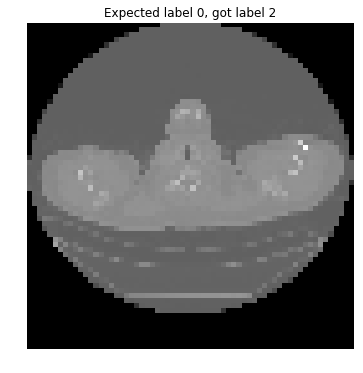

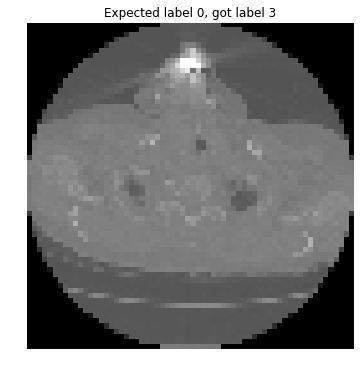

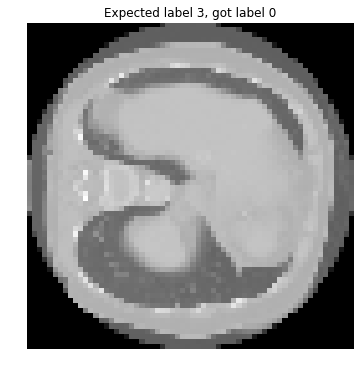

In [14]:
%matplotlib inline

for i in range(len(expected_label)):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.gca()
    ax.set_title('Expected label ' + str(expected_label[i]) + ', got label ' + str(mismatch_pred[i]))
    image = mismatch_images[i]
    plt.imshow(image.reshape(64, 64), cmap = 'gray')
    plt.axis('off')

In [15]:
submission_data_dir = os.path.join('data', 'test')
submission_file = 'submission_data.ctf'

def file_to_ndarray(file_root, imfile):
    return (imfile[:-4], np.array(Image.open(os.path.join(file_root, imfile))).reshape((-1, 64, 64)))

submission_images = [file_to_ndarray(submission_data_dir, f) for f in os.listdir(submission_data_dir)]
submission_images = sorted(submission_images, key = lambda x: x[0])
input_images = [x[1].astype(np.float32) / 255 for x in submission_images]

all_predictions = []

submission_mini_batch_size = 50

for i in range(0, 20000, submission_mini_batch_size):
    predictions = model(input_images[i:(i + submission_mini_batch_size)])
    all_predictions.append(np.argmax(predictions, axis = 1))
    
all_predictions = [item for sl in all_predictions for item in sl]

with open('submission_cntk.csv', 'w') as f:
    f.write('id,orientation\n')
    for i in range(20000):
        f.write(submission_images[i][0] + "," + str(all_predictions[i]) + "\n")

C:\Users\devg2\Anaconda3\lib\site-packages\cntk\core.py:411: UserWarning: you provided the minibatch data as a list, but your corresponding input variable (uid "Input3") has only one dynamic axis (batch axis). To speed up graph execution, please convert the data beforehand into one NumPy array to speed up training.
  'training.' % var.uid)
